In [ ]:
"""Import statements"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sbn

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


## ARIMA method as outlined in mod 5 lab

## What is ARIMA?

ARIMA stands for AutoRegressive Integrated Moving Average.
- Popular stats model used to forecast future values in a time series based on past values and errors.

An ARIMA model is defined as ARIMA(p, d, q), where:

- p (AutoRegressive): the number of past values (lags) the model uses to predict the future.
- d (Integrated): the number of times the data is differenced to remove trends and achieve stationarity.
- q (Moving Average): the number of past forecast errors the model uses to correct itself.


In this project, we attempt to forecast the monthly unemployment rate for the San Diego Metropolitan Statistical Area. We utilized ARIMA because:
- The raw unemployment rate shows a non-stationary trend.
- After differencing once (`d = 1`), the series becomes stationary.
- The ACF and PACF plots help identify appropriate values for `p` and `q`.

In [2]:
"""Load data and make it easier to work with """
san_diego = pd.read_csv("../Data/SANDIEGO.csv")
san_diego.rename(columns={"SAND706URN": "rate"}, inplace=True)
san_diego.rename(columns={"observation_date": "date"}, inplace=True)
san_diego.set_index("date", inplace=True)
san_diego.info()

<class 'pandas.core.frame.DataFrame'>
Index: 424 entries, 1990-01-01 to 2025-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rate    424 non-null    float64
dtypes: float64(1)
memory usage: 6.6+ KB


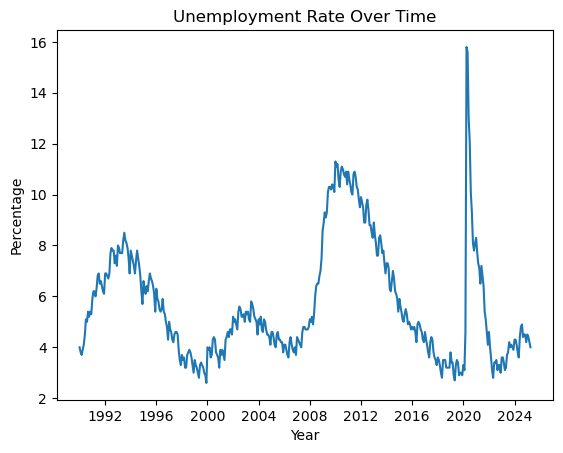

In [3]:
"""Create a time series and plot it to show changes over time"""
plt.title("Unemployment Rate Over Time")
plt.ylabel("Percentage")
plt.xlabel("Year")

time_series = pd.Series(san_diego["rate"].values, index=pd.date_range(start="1990-01-01", periods=len(san_diego), freq="MS"))
plt.plot(time_series)

plt.show()

This line graph displays the monthly unemployment rate in San Diego from 1990 to early 2025.

We see two major spikes:
- 2008-2009 represents the Great Recession
- 2020 represents COVID-19

Overall, the long-term trend remains generally cyclical. There are periods of high and low unemployment. This suggests that seasons and trends are present throughout. This is important for us when we decide whether ARIMA needs seasonal components or differencing.

In [5]:
"""Calculate rolling change from month to month, drop first entry for lack of prior knowledge"""
san_diego["change"] = san_diego["rate"].diff()
san_diego.dropna(inplace=True)
san_diego.head()

,rate,change
date,,
1990-02-01,3.8,-0.2
1990-03-01,3.7,-0.1
1990-04-01,3.9,0.2
1990-05-01,4.1,0.2
1990-06-01,4.5,0.4


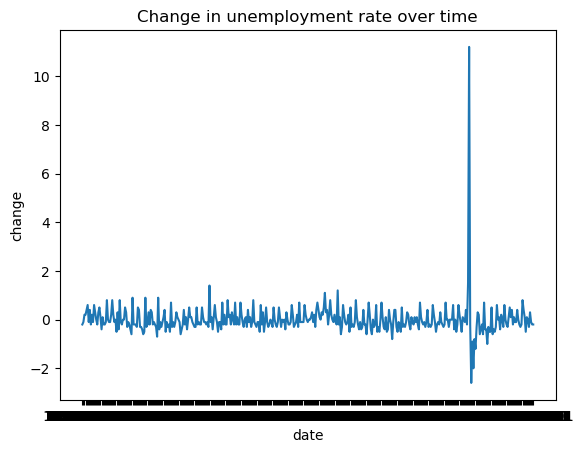

In [6]:
"""Plot rate change over time"""
# TODO: Fix xticks so that they aren't all bunched up and illegible (maybe make more sparce and turn 45 degrees)
sbn.lineplot(san_diego, x="date", y="change").set(title="Change in unemployment rate over time")
plt.show()

This line plot helps visualize how unemployment changes on a monthly basis. Specifically, it displays the volatility and the shifts in trends.

We see that typically the fluctuations hover around 0. The large spikes in either direction represent sudden economic shifts. Sharp rises represent periods of job losses, and sharp drops represent rapid job recovery or even seasonal hiring. The largest spike represents the impact of COVID-19.
It also shows that there is no obvious trend throughout the time period, meaning it supports the stationarity of the differenced series hence why we used d=1 in the ARIMA model.


In [7]:
"""Test for stability using Dickey Fuller test"""
dickey_fuller_raw = adfuller(san_diego["rate"])
dickey_fuller_diff = adfuller(san_diego["change"])

print("Augmented Dickey Fuller test on raw rate data:\n", dickey_fuller_raw)
print("Augmented Dickey Fuller test on change by month:\n", dickey_fuller_diff)

Augmented Dickey Fuller test on raw rate data:
 (np.float64(-2.68095072096676), np.float64(0.07739303070165421), 12, 410, {'1%': np.float64(-3.4464005219454155), '5%': np.float64(-2.868615280538588), '10%': np.float64(-2.570538905413444)}, np.float64(830.7677065906935))
Augmented Dickey Fuller test on change by month:
 (np.float64(-5.925719143440337), np.float64(2.4464824621891895e-07), 12, 410, {'1%': np.float64(-3.4464005219454155), '5%': np.float64(-2.868615280538588), '10%': np.float64(-2.570538905413444)}, np.float64(835.756726537898))


Note that for the raw rate data the ADF statistic is not more negative than the critical values, and the p-value is greater than 5%, indicating the data is not stationary

The change data, on the other hand, has an ADF statistic that is less than the critical values and a very low p-value, indicating the data is stationary. We will use the change data for this exercise

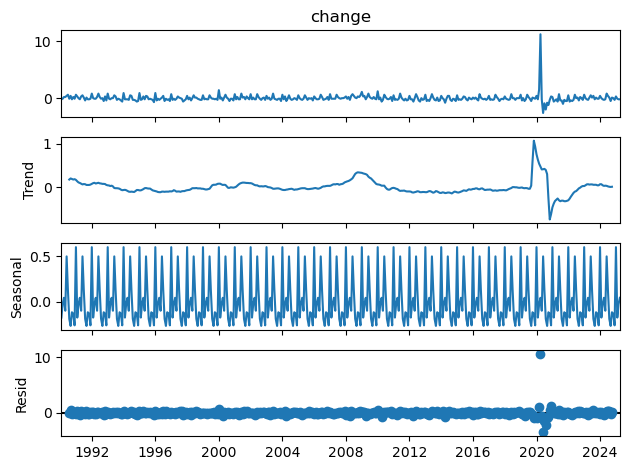

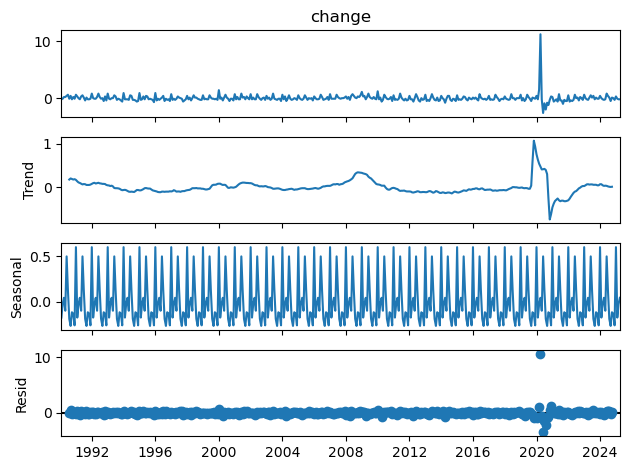

In [8]:
# TODO: research and provide information about this cell above
decompose_dataset = pd.DataFrame({"change": san_diego["change"], "date": pd.to_datetime(san_diego.index)})
decompose_dataset = decompose_dataset.set_index("date")

decomposition = seasonal_decompose(decompose_dataset["change"], model="additive")
trend = pd.DataFrame(decomposition.trend)
seasonal = pd.DataFrame(decomposition.seasonal)
residual = pd.DataFrame(decomposition.resid)
decomposition.plot()

The above plots arent used directly in ARIMA but simply help us visualize the data to gain a better understanding of seasons trends and residuals.

Trend: Seems to be flat, with periods of a moderate slope. Shows little long-term drift after differencing
Seasonal: Appears to have repetitive behaviour showing monthly seasonality
Residual: Random patterns

The main takeaway is that there is some seasonality, but not enough to require a SARIMA model.

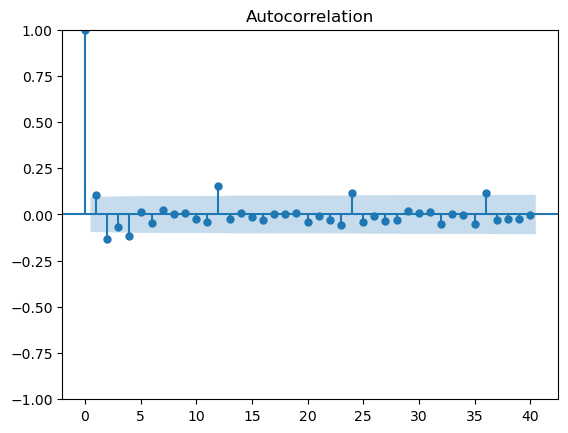

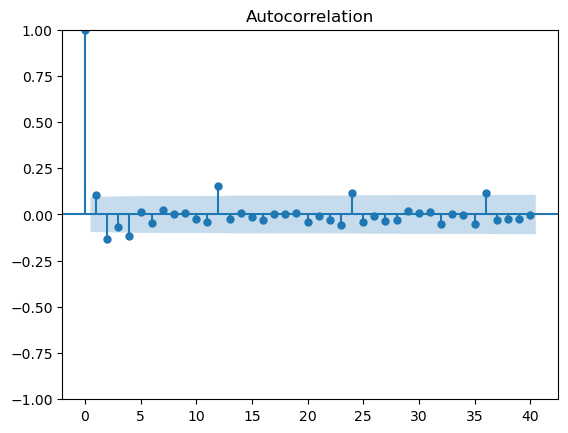

In [9]:
"""Plot the Autocorrelation Function"""
# TODO: figure out what this tells us and how we can optimize for the best number of "lags"
plot_acf(san_diego["change"], lags = 40)

The Autocorrelation Function shows us how a time series correlates to its own lagged values. The stronger the correlation between the current value and its past values, the higher the autocrrelation.

We see significant spikes at lags 1,2,3, and 12. The lag 12 spike shows seasonality in yearly intervals.

This helps support our selection of the q parameter in ARIMA - 13

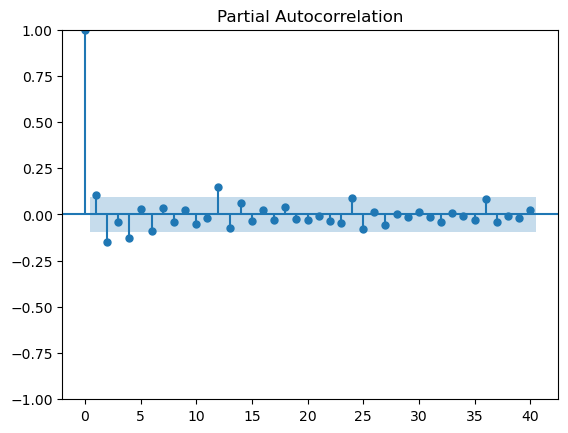

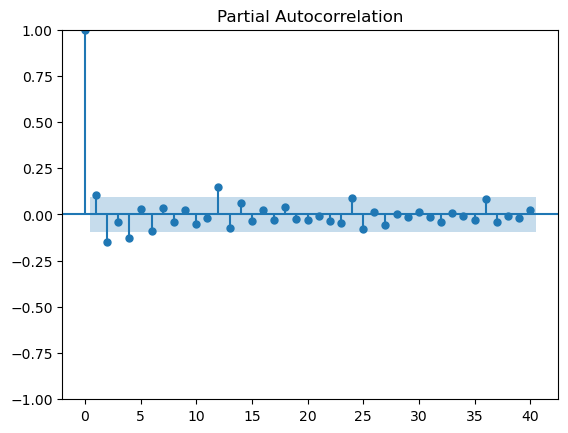

In [10]:
"""Plot the Partial Autocorrelation Function"""
# TODO: figure out what this tells us and how we can optimize for the best number of "lags"
plot_pacf(san_diego["change"], lags = 40)

The Partial Autocorrelation Function shows the correlation between the time series and its lagged values after taking away the short lags. This helps us determine the p value.

We see a sharp drop after lag 1 with multiple spikes up until lag 20. This shows us it is a autogressive structure because the value o a time series is dependent on its past values.

This led us to select p = 20.

In [11]:
"""Divide the data between training and testing data - All but most recent year as training, most recent year as test"""
san_diego_train = san_diego[san_diego.index < "2024-05-01"]
san_diego_test = san_diego[san_diego.index >= "2024-05-01"]

assert len(san_diego_train) + len(san_diego_test) == len(san_diego)
san_diego_train.tail()

,rate,change
date,,
2023-12-01,3.9,-0.1
2024-01-01,4.3,0.4
2024-02-01,4.3,0.0
2024-03-01,4.1,-0.2
2024-04-01,3.8,-0.3


In [16]:
"""Fit arima model (using rate data instead of change even though we said we would be using change... ??)"""
# TODO: Order is p, d, q -> no idea what they are for, nor how to optimize them
    #added some descriptions above to detail it!
import warnings
warnings.filterwarnings("ignore") # Suppress warnings for cleaner output
# TODO: Determine if rate or change is most appropriate
arima = ARIMA(san_diego_train["rate"], order=(20,1,13), freq="MS").fit()
train_preds = arima.predict()
train_preds

1990-02-01    0.000000
1990-03-01    3.800000
1990-04-01    3.699580
1990-05-01    3.903634
1990-06-01    4.109427
                ...   
2023-12-01    3.725092
2024-01-01    4.412364
2024-02-01    3.991211
2024-03-01    4.183430
2024-04-01    4.391135
Freq: MS, Name: predicted_mean, Length: 411, dtype: float64

In [13]:
"""Make predictions based on model training"""
# TODO: try multiple alpha levels and determine best level before committing to final model parameters
test_preds = arima.forecast(steps=13, alpha=0.05)

/opt/homebrew/anaconda3/envs/aai510/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


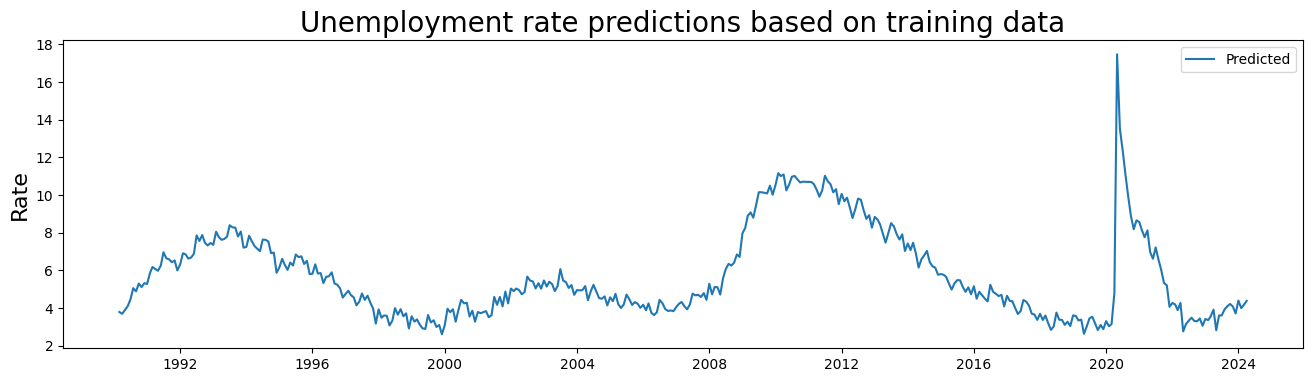

In [28]:
"""Plot the predicted data against the actual data"""
# TODO: Can plot one or the other, but plotting both causes an error -> likly becasue of difference in date info
plt.figure(figsize=(16,4))
plt.title("Unemployment rate predictions based on training data", fontsize=20)
plt.ylabel("Rate", fontsize=16)

# plt.plot(san_diego_train["rate"][1:], label="Actual")
plt.plot(train_preds[1:], label="Predicted")

plt.legend()
plt.show()

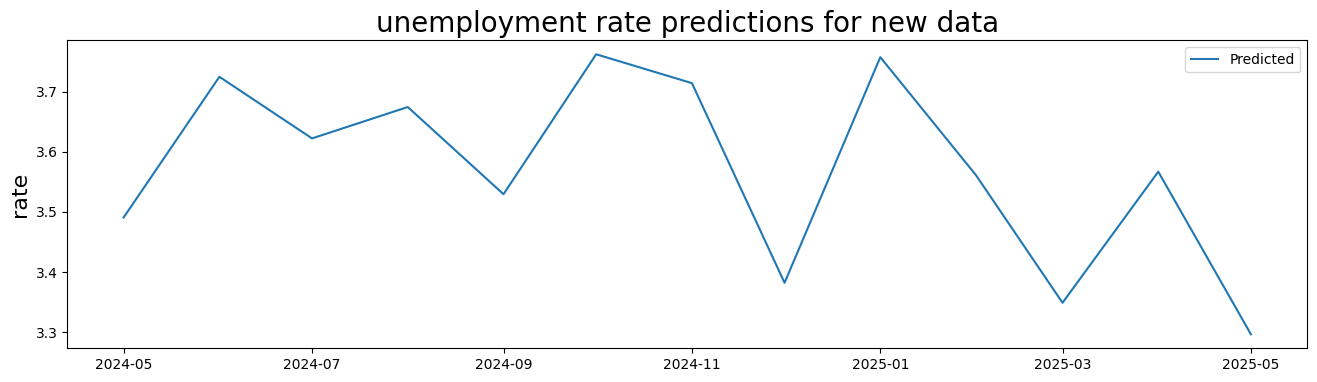

In [29]:
"""Plot the forecast data against the actual data"""
# TODO: Can plot one or the other, but plotting both causes an error -> likly becasue of difference in date info

plt.figure(figsize=(16,4))
plt.title("unemployment rate predictions for new data", fontsize=20)
plt.ylabel("rate", fontsize=16)

# plt.plot(san_diego_test["rate"], label="Actual")
plt.plot(test_preds, label="Predicted")

plt.legend()
plt.show()

Above is the forecasted unemployment rates for the next 13 months

## Various methodologies as outlined in [web resource](https://unravelthedata.com/time-series-forecasting-with-unemployment-data/)

TODO: Research all the methods below and see if any of them represent the data more accurately/appropriately than the ARIMA model above.

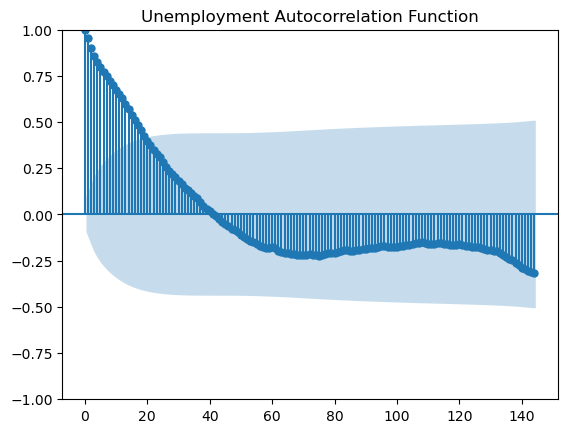

In [18]:
plot_acf(san_diego["rate"], lags=144) # Plot ACF for rate data
plt.title("Unemployment Autocorrelation Function") # Title for ACF plot
plt.show()

In [ ]:
# Partitioning
# The time/train split method from sklearn
test_size = max(int(len(time_series) * 0.2), 4)
test = time_series[-test_size:]
print(len(test))
training = time_series[:-test_size]
print(len(training))

84
340


In [20]:
# naive Method
naive = training[-1]
naive_forecast = np.repeat(naive, test_size)
print(naive_forecast)

[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]


In [23]:
# drift Method
drift = np.linspace(training.iloc[-1], training.iloc[-1] + (training.iloc[-1] - training.iloc[-2]), test_size)
print(drift)

[3.         2.99638554 2.99277108 2.98915663 2.98554217 2.98192771
 2.97831325 2.9746988  2.97108434 2.96746988 2.96385542 2.96024096
 2.95662651 2.95301205 2.94939759 2.94578313 2.94216867 2.93855422
 2.93493976 2.9313253  2.92771084 2.92409639 2.92048193 2.91686747
 2.91325301 2.90963855 2.9060241  2.90240964 2.89879518 2.89518072
 2.89156627 2.88795181 2.88433735 2.88072289 2.87710843 2.87349398
 2.86987952 2.86626506 2.8626506  2.85903614 2.85542169 2.85180723
 2.84819277 2.84457831 2.84096386 2.8373494  2.83373494 2.83012048
 2.82650602 2.82289157 2.81927711 2.81566265 2.81204819 2.80843373
 2.80481928 2.80120482 2.79759036 2.7939759  2.79036145 2.78674699
 2.78313253 2.77951807 2.77590361 2.77228916 2.7686747  2.76506024
 2.76144578 2.75783133 2.75421687 2.75060241 2.74698795 2.74337349
 2.73975904 2.73614458 2.73253012 2.72891566 2.7253012  2.72168675
 2.71807229 2.71445783 2.71084337 2.70722892 2.70361446 2.7       ]


In [ ]:
# Simple average method
avg = np.mean(training)
avg_forecast = np.repeat(avg, test_size)
print(avg_forecast)

[5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235
 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235 5.91088235]


In [37]:
# Exponential Smoothing
smoothing = ExponentialSmoothing(training, seasonal=None).fit()
smoothing_forecast = smoothing.forecast(test_size)
print(smoothing_forecast)

2018-05-31    3.013729
2018-06-30    3.013729
2018-07-31    3.013729
2018-08-31    3.013729
2018-09-30    3.013729
                ...   
2024-12-31    3.013729
2025-01-31    3.013729
2025-02-28    3.013729
2025-03-31    3.013729
2025-04-30    3.013729
Freq: ME, Length: 84, dtype: float64


In [38]:
# Exponential Smoothing with different alphas
alphas = [0.1, 0.3, 0.5, 0.7, 0.9]
for alpha in alphas:
    smoothing_alpha = ExponentialSmoothing(training, smoothing_level=alpha, seasonal=None).fit()
    smoothing_alpha_forecast = smoothing_alpha.forecast(test_size)
    print(f"smoothing with alpha={alpha}: {smoothing_alpha_forecast}")

TypeError: ExponentialSmoothing.__init__() got an unexpected keyword argument 'smoothing_level'

In [27]:
# holt Method
holt_model = Holt(training).fit()
holt_forecast = holt_model.forecast(test_size)
print(holt_forecast)

2018-05-31    2.938271
2018-06-30    2.855288
2018-07-31    2.772305
2018-08-31    2.689322
2018-09-30    2.606339
                ...   
2024-12-31   -3.617390
2025-01-31   -3.700373
2025-02-28   -3.783356
2025-03-31   -3.866339
2025-04-30   -3.949322
Freq: ME, Length: 84, dtype: float64


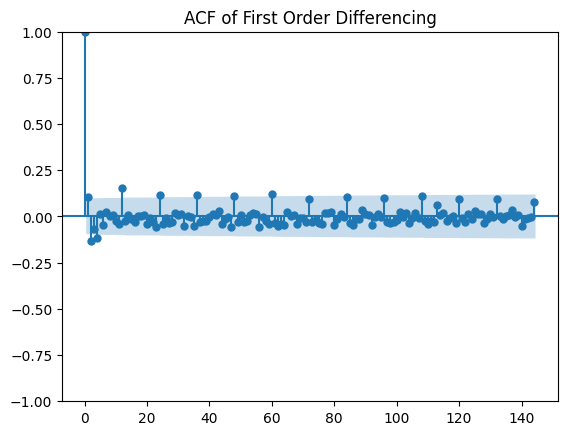

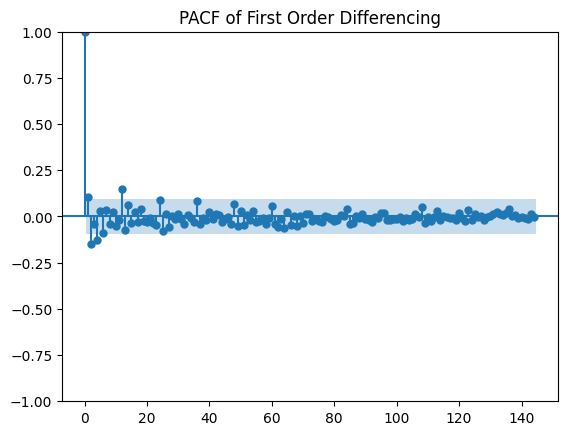

In [28]:
# ACF and PACF of first order differencing
dff = time_series.diff().dropna()
plot_acf(dff, lags=144)
plt.title("ACF of First Order Differencing")
plt.show()
plot_pacf(dff, lags=144)
plt.title("PACF of First Order Differencing")
plt.show()


In [30]:
# ARIMA Models
model_1 = ARIMA(training, order=(1, 1, 1)).fit()
print(model_1.summary())
model_2 = ARIMA(training, order=(1, 0, 1)).fit()
print(model_2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  340
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -129.211
Date:                Thu, 29 May 2025   AIC                            264.422
Time:                        11:30:15   BIC                            275.900
Sample:                    01-31-1990   HQIC                           268.996
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4372      0.573      0.763      0.445      -0.686       1.560
ma.L1         -0.5177      0.534     -0.970      0.332      -1.564       0.528
sigma2         0.1255      0.009     14.351      0.0

/home/poppop/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/poppop/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [31]:
# Predictions
model_1_predictions = model_1.forecast(steps=test_size)
model_2_predictions = model_2.forecast(steps=test_size)
print(f"Model_1 Predictions: {model_1_predictions}")
print(f"Model_2 Predictions: {model_2_predictions}")

Model_1 Predictions: 2018-05-31    3.033426
2018-06-30    3.048041
2018-07-31    3.054431
2018-08-31    3.057225
2018-09-30    3.058446
                ...   
2024-12-31    3.059395
2025-01-31    3.059395
2025-02-28    3.059395
2025-03-31    3.059395
2025-04-30    3.059395
Freq: ME, Name: predicted_mean, Length: 84, dtype: float64
Model_2 Predictions: 2018-05-31    3.038500
2018-06-30    3.064233
2018-07-31    3.089650
2018-08-31    3.114755
2018-09-30    3.139552
                ...   
2024-12-31    4.345155
2025-01-31    4.354862
2025-02-28    4.364451
2025-03-31    4.373922
2025-04-30    4.383276
Freq: ME, Name: predicted_mean, Length: 84, dtype: float64


In [32]:
# Accuracy
print("Model_1 MAE:", mean_absolute_error(test, model_1_predictions))
print("Model_2 MAE:", mean_absolute_error(test, model_2_predictions))

Model_1 MAE: 1.8139774991017772
Model_2 MAE: 1.462163738225472


In [33]:
# Simple moving average
moving_average_model = np.mean(time_series)
predictions = np.repeat(moving_average_model, 3)
print(predictions)

[5.69811321 5.69811321 5.69811321]


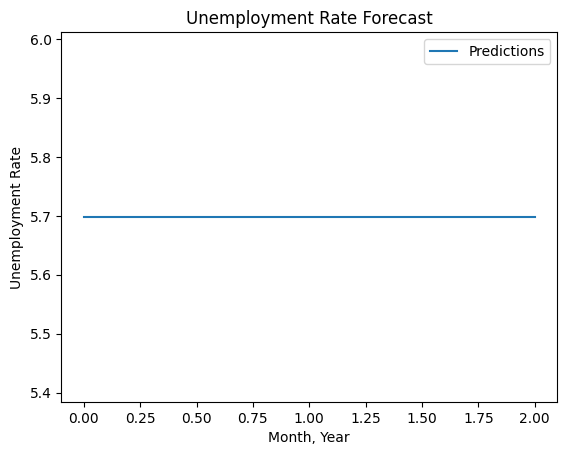

In [34]:
# Plot predictions
plt.plot(predictions, label="Predictions")
plt.title("Unemployment Rate Forecast")
plt.ylabel("Unemployment Rate")
plt.xlabel("Month, Year")
plt.legend()
plt.show()
